In [29]:
%run stat_extracter.py

Finished processing the log files and writing to the CSV file.
Finished adding client lines to the output CSV file.


[2801, 5001, 7001, 9101, 11301, 13601, 16001, 18401, 20801, 23401, 26001, 28701, 31301, 34001, 36601, 39201, 41801, 44301, 46801, 49401, 52101, 54701, 57201, 59901, 62601, 65501, 68001, 70801, 73401, 76201, 79101, 81901, 84801, 87601, 90301, 93401, 96201, 99001, 101701, 104501, 107301, 110001, 112801, 115701, 118501, 121401, 124201, 127001, 129801, 132801, 135801, 138601, 141601, 144401, 147401, 150201, 153201, 156101, 159001, 161901, 165001, 168301, 171401, 174601, 177501, 180501, 183501, 186401, 189301, 192201, 195101, 197901, 200801, 203801, 206701, 209401, 212601, 215601, 218501, 221501, 224601, 227501, 230501, 233701, 236701, 239801, 243001, 246201, 249301, 250000]
[21.8828125, 17.1875, 15.625, 16.40625, 17.1875, 17.96875, 18.75, 18.75, 18.75, 20.3125, 20.3125, 21.09375, 20.3125, 21.09375, 20.3125, 20.3125, 20.3125, 19.53125, 19.53125, 20.3125, 21.09375, 20.3125, 19.53125, 21.09375, 21.09375, 22.65625, 19.53125, 21.875, 20.3125, 21.875, 22.65625, 21.875, 22.65625, 21.875, 21.09375

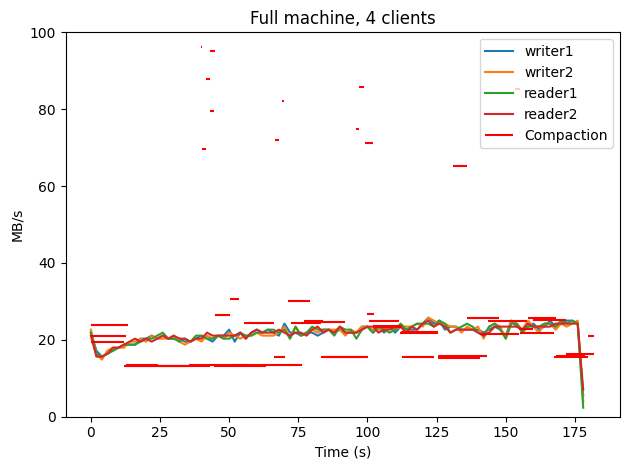

In [30]:
import csv
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta

# Path to your final output CSV file
csv_file_path = 'output.csv'

# Function to convert micros since epoch to datetime object
def micros_since_epoch_to_datetime(micros):
    return datetime(1970, 1, 1) + timedelta(microseconds=int(micros))

# Initialize dictionaries to hold data for each client and compaction_finished events
client_data = {}
compaction_events = []
stall_events = []

# Read the CSV file
with open(csv_file_path, 'r') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        # Process client data
        if row[0].startswith('client'):
            client_id = row[0]
            start_time_micros = micros_since_epoch_to_datetime(row[1])
            operation_counts = [int(count) for count in row[2:]]
            print(operation_counts)
            for i in range(len(operation_counts)-1, 0, -1):
              operation_counts[i] -= operation_counts[i-1] 
            for i in range(len(operation_counts)):
              operation_counts[i] = operation_counts[i] / 2 * 16 / 1024 # MB/s
              # IF read AND update --> get rid of reads
              # operation_counts[i] = operation_counts[i] / 2 * 16 / 1024 /2 # MB/s
            print(operation_counts)
            print()
            if client_id == "client1":
               client_id = "writer1"
            elif client_id == "client2":
               client_id = "writer2"
            else:
                client_id = "reader" + str(int(client_id[-1])-2)
            client_data[client_id] = {
                'start_time': start_time_micros,
                'operation_counts': operation_counts
            }
        # Process compaction_finished events
        elif row[0] == 'compaction_finished':
          end_time_micros = int(row[1])
          compaction_time_micros = int(row[2])
          start_time_micros = end_time_micros - compaction_time_micros
          total_output_size = int(row[3])
          # Convert times to datetime for plotting
          start_time = micros_since_epoch_to_datetime(start_time_micros)
          end_time = micros_since_epoch_to_datetime(end_time_micros)
          # Calculate y-value
          duration_seconds = (end_time_micros - start_time_micros) / 1e6
          y_value = total_output_size / (1024 * 1024 * duration_seconds)
          compaction_events.append((start_time, end_time, y_value))

        elif row[0] == 'stall_started':
          stall_time_micros = int(row[1])
          rate_bytes_per_sec = int(row[2])  # Assuming 'rate' is in bytes per second
          # Convert timestamp to datetime for plotting
          stall_time = micros_since_epoch_to_datetime(stall_time_micros)
          # Calculate y-value in MB/s
          y_value = rate_bytes_per_sec / (1024 * 1024)
          stall_events.append((stall_time, y_value))

experiment_start_time = min([data['start_time'] for client_id, data in client_data.items()] +
                            [event[0] for event in compaction_events] +
                            [event[0] for event in stall_events])

# Plotting
fig, ax = plt.subplots()

# Plot client data
for client_id, data in client_data.items():
    operation_counts = data['operation_counts']
    time_offsets = [2 * i for i in range(len(operation_counts))]
    # Convert start time to seconds since the start of the experiment
    start_seconds_since_experiment = (data['start_time'] - experiment_start_time).total_seconds()
    times = [start_seconds_since_experiment + offset for offset in time_offsets]
    ax.plot(times, operation_counts, '-', label=client_id)

# Plot compaction events
for start_time, end_time, y_value in compaction_events:
    start_seconds = (start_time - experiment_start_time).total_seconds()
    end_seconds = (end_time - experiment_start_time).total_seconds()
    ax.hlines(y=y_value, xmin=start_seconds, xmax=end_seconds, colors='r', linestyles='solid', label='Compaction' if compaction_events.index((start_time, end_time, y_value)) == 0 else "")

# Plot stall events
for stall_time, y_value in stall_events:
    stall_seconds = (stall_time - experiment_start_time).total_seconds()
    ax.scatter(stall_seconds, y_value, color='g', label='Stall Started' if stall_events.index((stall_time, y_value)) == 0 else "")

# Update labels and formatting
plt.xlabel('Time (s)')
plt.ylabel('MB/s')
plt.title('Full machine, 4 clients')
plt.ylim(0, 100)
# plt.xlim(0, 120)
plt.legend()
plt.tight_layout()
plt.show()

In [6]:
import re
import csv

# Define the file paths
input_file_path = 'status_thread.txt'
output_file_path = 'client_stats.csv'

# Initialize a dictionary to hold the data
client_data = {}

# Compile the regular expressions for matching lines
client_regex = re.compile(r'client(\d+) stats:')
data_regex = re.compile(r'(\d+) operations; \[(READ|UPDATE): Count=(\d+) Max=\d+\.\d+ Min=\d+\.\d+ Avg=(\d+\.\d+) 90=\d+\.\d+ 99=(\d+\.\d+) 99.9=(\d+\.\d+) 99.99=\d+\.\d+\]')
# Open and read the input file
with open(input_file_path, 'r') as file:
    lines = file.readlines()

    for i, line in enumerate(lines):
        client_match = client_regex.match(line)
        if client_match:
            client_id = client_match.group(1)
            # Check if the next line contains the data
            if i + 1 < len(lines):
                data_match = data_regex.match(lines[i + 1])
                if data_match:
                    # Extract the relevant data
                    _, count, avg, p99, p999 = data_match.group(2, 3, 4, 5, 6)
                    # Check if the client ID already exists in the dictionary
                    if client_id not in client_data:
                        client_data[client_id] = {'Count': [], 'Avg': [], '99': [], '999': []}
                    # Append the data to the lists in the dictionary
                    client_data[client_id]['Count'].append(count)
                    client_data[client_id]['Avg'].append(avg)
                    client_data[client_id]['99'].append(p99)
                    client_data[client_id]['999'].append(p999)

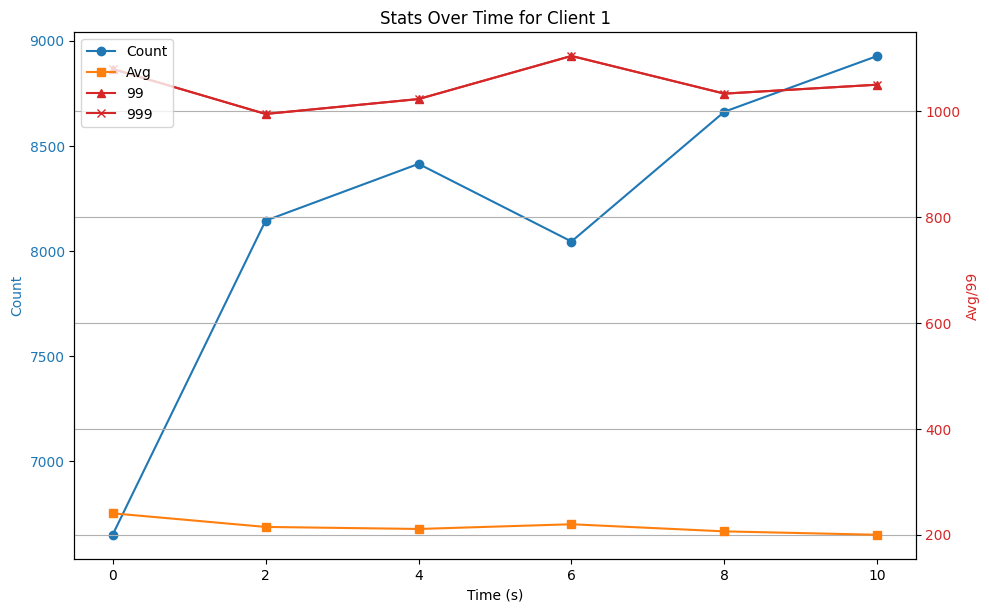

In [8]:
import matplotlib.pyplot as plt

# Specify which client's data to plot (e.g., '1' for client1)
client_id_to_plot = '1'

if client_id_to_plot in client_data:
    # Extract the data for the specified client
    counts = [int(x) for x in client_data[client_id_to_plot]['Count']]
    avgs = [float(x) for x in client_data[client_id_to_plot]['Avg']]
    nines = [float(x) for x in client_data[client_id_to_plot]['99']]
    nines = [float(x) for x in client_data[client_id_to_plot]['999']]
    
    # Generate time points (2s intervals)
    time_points = [2 * i for i in range(len(counts))]
    
    # Creating the plot
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plotting 'Count' on the primary y-axis
    color = 'tab:blue'
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Count', color=color)
    ax1.plot(time_points, counts, label='Count', marker='o', color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    # Creating a second y-axis for 'Avg' and '99'
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Avg/99', color=color)
    ax2.plot(time_points, avgs, label='Avg', marker='s', color='tab:orange')
    ax2.plot(time_points, nines, label='99', marker='^', color=color)
    ax2.plot(time_points, nines, label='999', marker='x', color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    # Title and grid
    fig.tight_layout()
    plt.title(f'Stats Over Time for Client {client_id_to_plot}')
    plt.grid(True)

    # Legends
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper left')

    plt.show()
else:
    print(f"No data found for client {client_id_to_plot}.")
